In [15]:
import optuna
from optuna.samplers import TPESampler
import warnings

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBClassifier
from collections import Counter

warnings.filterwarnings("ignore")

### Filter labevents (to include only patients of interest)

In [ ]:
subject_id = pd.read_csv("patients_subject_id.csv")
patients_df = pd.read_csv("patients.csv")

In [25]:
from pathlib import Path
filtered_labevents_path_to_save = Path("E:/Chrome Dls/MIMIC_IV_Core/hosp/filtered_labevents.csv")

if filtered_labevents_path_to_save.exists():
    filtered_labevents = pd.read_csv(filtered_labevents_path_to_save)
else:
    # for faster lookup
    pat_set = set(subject_id["subject_id"].values)

    # path to compressed file
    file_path = "E:/Chrome Dls/MIMIC_IV_Core/hosp/labevents.csv"

    # read in chunks of 500,000 rows
    chunksize = 500000
    chunks = pd.read_csv(file_path, chunksize=chunksize, low_memory=False)

    # Example: loop through chunks to filter only hypertension patients
    filtered_chunks = []
    for chunk in chunks:
        # keep only patients of interest (pat_set is your subject_id set)
        chunk = chunk[chunk['subject_id'].isin(pat_set)]
        filtered_chunks.append(chunk)

    # concatenate all filtered results into one DataFrame
    filtered_labevents = pd.concat(filtered_chunks, ignore_index=True)

    print("Rows kept:", len(filtered_labevents))

    cols_keep = ['subject_id','itemid','charttime','valuenum','valueuom', 'ref_range_lower', 'ref_range_upper', 'flag']
    filtered_labevents = filtered_labevents.loc[:, cols_keep].copy()

Rows kept: 24689530


In [26]:
# filtered_labevents.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
print(filtered_labevents.shape)
filtered_labevents.head()

(24689530, 8)


,subject_id,itemid,charttime,valuenum,valueuom,ref_range_lower,ref_range_upper,flag
0,10000032,50931,2180-03-23 11:51:00,95.0,mg/dL,70.0,100.0,NaN
1,10000032,51071,2180-03-23 11:51:00,NaN,NaN,NaN,NaN,NaN
2,10000032,51074,2180-03-23 11:51:00,NaN,NaN,NaN,NaN,NaN
3,10000032,51075,2180-03-23 11:51:00,NaN,NaN,NaN,NaN,NaN
4,10000032,51079,2180-03-23 11:51:00,NaN,NaN,NaN,NaN,NaN


### Checkpoint

In [28]:
filtered_labevents.to_csv(filtered_labevents_path_to_save, index=False)

### Select most important lab items from d_labitmes.csv

In [29]:
d_labitems_df = pd.read_csv(
    f"E:/Chrome Dls/MIMIC_IV_Core/hosp/d_labitems.csv"
)

print(d_labitems_df['label'].value_counts(normalize=True))

label
Delete                           0.019441
Voided Specimen                  0.012151
Beta                             0.004860
Alpha-1                          0.004860
Alpha-2                          0.004860
                                   ...   
WBC Count                        0.000608
Wright Giemsa                    0.000608
Hematocrit, Joint Fluid          0.000608
Joint Crystals, Birefringence    0.000608
MXD%                             0.000608
Name: proportion, Length: 1191, dtype: float64


In [30]:
# 1. Find labels matching keywords
keywords = ['creatinine','glucose','potassium','sodium','hemoglobin','hematocrit','calcium','albumin']
mask = d_labitems_df['label'].str.contains('|'.join(keywords), case=False, na=False)
candidates = d_labitems_df[mask]
print("Candidate lab items:\n", candidates[['itemid','label']].head(20))

# 2. Count frequency in labevents (in chunks) to filter by occurrence threshold
counts = Counter()

# only labs for admissions you're analyzing (optional filter by hadm_id)
counts.update(filtered_labevents['itemid'].tolist())

# Turn into DataFrame
counts_df = pd.DataFrame(list(counts.items()), columns=['itemid','count'])
# Merge with label info
counts_df = counts_df.merge(d_labitems_df[['itemid','label']], on='itemid', how='left')
# Filter for high frequency labs
freq_thresh = 500  # threshold, e.g. appear in at least 500 records
common_labs = counts_df[counts_df['count'] > freq_thresh]
print("\n\ncommon_labs sorted:\n", common_labs.sort_values(by='count', ascending=False).head(20))


Candidate lab items:
      itemid                   label
4     50805       Carboxyhemoglobin
6     50808            Free Calcium
7     50809                 Glucose
8     50810  Hematocrit, Calculated
9     50811              Hemoglobin
12    50814           Methemoglobin
20    50822  Potassium, Whole Blood
22    50824     Sodium, Whole Blood
31    50833               Potassium
32    50834      Sodium, Body Fluid
33    50835        Albumin, Ascites
39    50841     Creatinine, Ascites
40    50842        Glucose, Ascites
45    50847      Potassium, Ascites
46    50848         Sodium, Ascites
50    50852        % Hemoglobin A1c
53    50855     Absolute Hemoglobin
60    50862                 Albumin
91    50893          Calcium, Total
110   50912              Creatinine


common_labs sorted:
     itemid   count              label
25   50912  682785         Creatinine
50   51221  681922         Hematocrit
45   51006  665270      Urea Nitrogen
58   51265  662406     Platelet Count
39   5097

In [32]:
# Creatinine, BUN, Sodium, Potassium, Chloride, Bicarbonate, Anion Gap, Glucose
candidate_items = (50912, 51006, 50983, 50971, 50902, 50882, 50868, 50931)

In [34]:
# 1.1 filter to candidate items (if not already)
df = filtered_labevents[filtered_labevents['itemid'].isin(candidate_items)].copy()

# Ensure numeric types
df['valuenum'] = pd.to_numeric(df['valuenum'], errors='coerce')
df['ref_range_lower'] = pd.to_numeric(df['ref_range_lower'], errors='coerce')
df['ref_range_upper'] = pd.to_numeric(df['ref_range_upper'], errors='coerce')

# 1.2 aggregate per (subject_id, itemid)
agg = df.groupby(['subject_id','itemid']).agg(
    mean_valuenum = ('valuenum','mean'),
    ref_lower_med = ('ref_range_lower','median'),   # median reference lower for that subject-item
    ref_upper_med = ('ref_range_upper','median'),
    n_obs = ('valuenum','count'),
    any_abnormal = ('flag', lambda x: x.eq('abnormal').any())
).reset_index()

# 1.3 pivot so each itemid becomes columns
mean_pivot = agg.pivot(index='subject_id', columns='itemid', values='mean_valuenum')
ref_lower_pivot = agg.pivot(index='subject_id', columns='itemid', values='ref_lower_med')
ref_upper_pivot = agg.pivot(index='subject_id', columns='itemid', values='ref_upper_med')
nobs_pivot = agg.pivot(index='subject_id', columns='itemid', values='n_obs')
abn_pivot = agg.pivot(index='subject_id', columns='itemid', values='any_abnormal')

# 1.4 rename columns to readable names and join
def rename_cols(df_pivot, suffix):
    df_pivot = df_pivot.add_prefix('item_').rename(columns=lambda c: f"{c}_{suffix}")
    # pivot columns are currently like 'item_50912' etc; ensure consistent naming
    return df_pivot

mean_pivot = rename_cols(mean_pivot, 'mean')
ref_lower_pivot = rename_cols(ref_lower_pivot, 'ref_lower')
ref_upper_pivot = rename_cols(ref_upper_pivot, 'ref_upper')
nobs_pivot = rename_cols(nobs_pivot, 'count')
abn_pivot = rename_cols(abn_pivot, 'any_abnormal')

# join all together
result = mean_pivot.join([ref_lower_pivot, ref_upper_pivot, nobs_pivot, abn_pivot], how='outer').reset_index()

# Optional: fill NaN means with some sentinel or leave as NaN
print(result.shape)
result.head()


(35908, 41)


itemid,subject_id,item_50868_mean,item_50882_mean,item_50902_mean,item_50912_mean,item_50931_mean,item_50971_mean,item_50983_mean,item_51006_mean,item_50868_ref_lower,...,item_50983_count,item_51006_count,item_50868_any_abnormal,item_50882_any_abnormal,item_50902_any_abnormal,item_50912_any_abnormal,item_50931_any_abnormal,item_50971_any_abnormal,item_50983_any_abnormal,item_51006_any_abnormal
0,10000032,11.222222,25.388889,97.047619,0.466667,106.176471,5.100000,128.700000,30.388889,8.0,...,20.0,18.0,True,True,True,True,True,True,True,True
1,10000084,12.833333,23.166667,100.666667,0.733333,95.833333,4.350000,136.666667,12.666667,10.0,...,6.0,6.0,False,True,False,False,True,True,True,False
2,10000108,15.000000,29.000000,101.000000,1.000000,88.000000,3.500000,141.000000,12.000000,8.0,...,1.0,1.0,False,False,False,False,False,False,False,False
3,10000117,16.928571,23.714286,102.533333,0.868750,85.416667,4.073333,140.666667,10.066667,8.0,...,15.0,15.0,True,False,False,False,True,True,False,False
4,10000161,10.500000,27.000000,102.500000,0.966667,101.000000,4.200000,140.000000,19.000000,10.0,...,2.0,3.0,False,False,False,False,True,False,False,False


In [43]:
# d_labitems_df should be loaded earlier
mapping = d_labitems_df.set_index('itemid')['label'].to_dict()
# example to rename columns after `result` is built:
new_cols = {}
for col in result.columns:
    if col.startswith('item_') and col.endswith('_mean'):
        item = int(col.split('_')[1])
        name = mapping.get(item, str(item)).replace(' ','_').replace('/','_')
        new_cols[col] = f"{name}_mean"
    # similarly for ref_lower/ref_upper/count/any_abnormal
    if col.startswith('item_') and col.endswith('_lower'):
        item = int(col.split('_')[1])
        name = mapping.get(item, str(item)).replace(' ','_').replace('/','_')
        new_cols[col] = f"{name}_lower"
    # similarly for ref_lower/ref_upper/count/any_abnormal
    if col.startswith('item_') and col.endswith('_upper'):
        item = int(col.split('_')[1])
        name = mapping.get(item, str(item)).replace(' ','_').replace('/','_')
        new_cols[col] = f"{name}_upper"
    # similarly for ref_lower/ref_upper/count/any_abnormal
    if col.startswith('item_') and col.endswith('_count'):
        item = int(col.split('_')[1])
        name = mapping.get(item, str(item)).replace(' ','_').replace('/','_')
        new_cols[col] = f"{name}_count"
    # simil
    if col.startswith('item_') and col.endswith('_abnormal'):
        item = int(col.split('_')[1])
        name = mapping.get(item, str(item)).replace(' ','_').replace('/','_')
        new_cols[col] = f"{name}_any_abnormal"
result = result.rename(columns=new_cols)

# Keep only subject_id and *_mean columns
result = result[["subject_id"] + [c for c in result.columns if c.endswith("_mean")]]

print(result.shape)
result.head()

(35908, 9)


itemid,subject_id,Anion_Gap_mean,Bicarbonate_mean,Chloride_mean,Creatinine_mean,Glucose_mean,Potassium_mean,Sodium_mean,Urea_Nitrogen_mean
0,10000032,11.222222,25.388889,97.047619,0.466667,106.176471,5.100000,128.700000,30.388889
1,10000084,12.833333,23.166667,100.666667,0.733333,95.833333,4.350000,136.666667,12.666667
2,10000108,15.000000,29.000000,101.000000,1.000000,88.000000,3.500000,141.000000,12.000000
3,10000117,16.928571,23.714286,102.533333,0.868750,85.416667,4.073333,140.666667,10.066667
4,10000161,10.500000,27.000000,102.500000,0.966667,101.000000,4.200000,140.000000,19.000000


In [46]:
missing_values_prop = result.isnull().mean()
a = missing_values_prop*100.0
print("missings proportion:\n", a)

missings proportion:
 itemid
subject_id            0.000000
Anion_Gap_mean        2.016264
Bicarbonate_mean      2.007909
Chloride_mean         1.893728
Creatinine_mean       0.595967
Glucose_mean          1.127882
Potassium_mean        1.843600
Sodium_mean           1.868664
Urea_Nitrogen_mean    1.061045
dtype: float64


In [48]:
print(len(np.unique(filtered_labevents.subject_id)))
print(len(np.unique(result.subject_id)))

36342
35908


### save result

In [ ]:
result.to_csv("labevents_summary.csv", index=False)

# Optinal (why we calculate mean for items??)

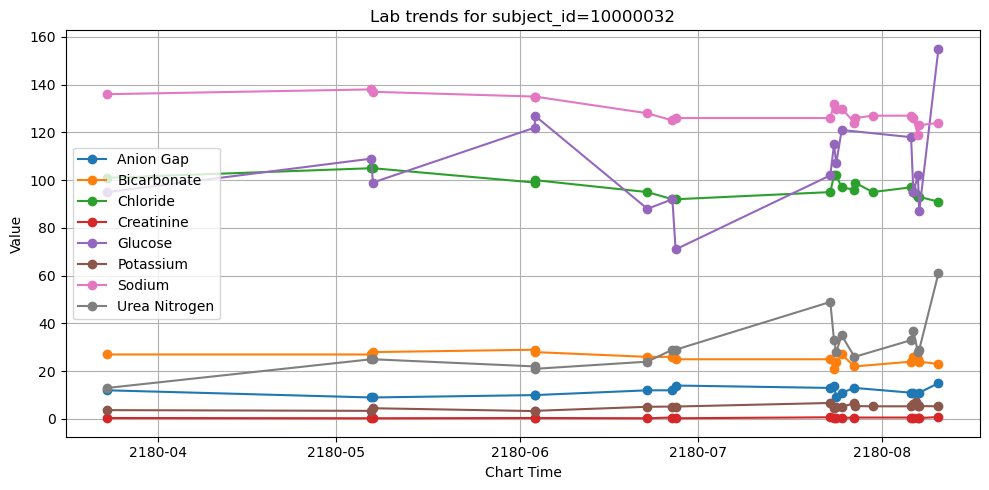

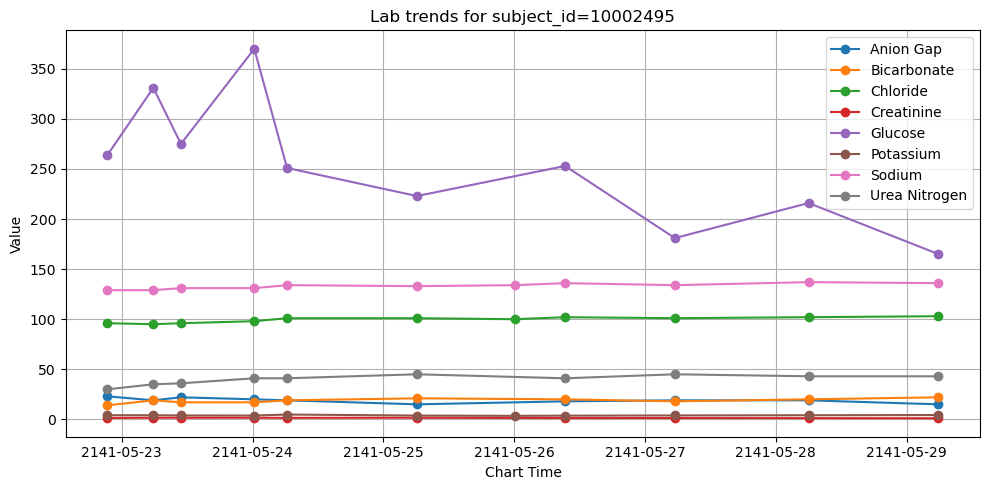

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your filtered labevents (already reduced dataset)
df = pd.read_csv("E:/Chrome Dls/MIMIC_IV_Core/hosp/filtered_labevents.csv", parse_dates=["charttime"])

# Keep only selected subject_ids and itemids
subject_ids = [10000032, 10002495]
itemids = [50912, 51006, 50983, 50971, 50902, 50882, 50868, 50931]  # Creatinine, Urea Nitrogen

df_plot = df[df['subject_id'].isin(subject_ids) & df['itemid'].isin(itemids)].copy()

# Map itemid → label for readability
itemid_to_label = {
    50912: "Creatinine",
    51006: "Urea Nitrogen",
    50983: "Sodium",
    50971: "Potassium",
    50902: "Chloride",
    50882: "Bicarbonate",
    50868: "Anion Gap",
    50931: "Glucose"
}
df_plot['label'] = df_plot['itemid'].map(itemid_to_label)

# Plot for each patient separately
for sid in subject_ids:
    plt.figure(figsize=(10,5))
    temp = df_plot[df_plot['subject_id'] == sid]

    for label, group in temp.groupby("label"):
        plt.plot(group['charttime'], group['valuenum'], marker='o', label=label)

    plt.title(f"Lab trends for subject_id={sid}")
    plt.xlabel("Chart Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
